# Grad-based XAI with a CNN (PyTorch)

We will:
1) Load a pretrained CNN (ResNet-50).
2) Run inference on an image.
3) Explain *gradient-based* XAI:
   - Saliency (input gradients)
   - SmoothGrad (noise-averaged saliency)
   - Integrated Gradients (path attribution)

Why gradients?
- If the model's output changes a lot when a pixel changes a little, gradients become large.
- Gradient maps are the simplest “what pixels matter for this prediction?” explanation.


In [1]:
import os
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

from PIL import Image
# from torchvision import models, transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [2]:
import importlib
import scripts.xai_setup as setup

importlib.reload(setup)

<module 'scripts.xai_setup' from 'e:\\PHD\\datacloud_data\\repos\\my_git\\explainable_ai\\scripts\\xai_setup.py'>

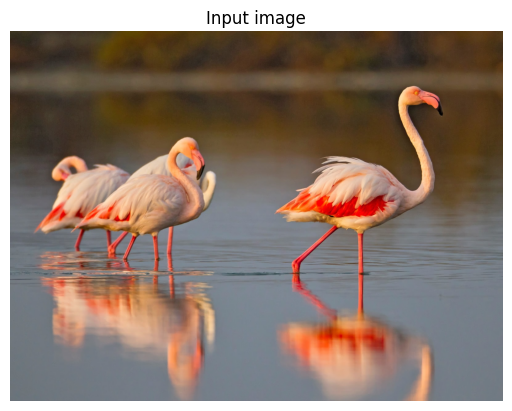

In [3]:
img_path = "assets/flamingo.jpg"   # change if needed
pil = Image.open(img_path).convert("RGB")

setup.show(pil, "Input image")


In [4]:
import scripts.xai_setup as setup

# from setup import *

In [5]:
# model, preprocess, class_names, device, predict_proba, predict_topk = setup.xai_setup("resnet50") 
model, preprocess, class_names, device, predict_proba, predict_topk = setup.xai_setup("resnet18") 
# model, preprocess, class_names, device, predict_proba, predict_topk = setup.xai_setup("mobilenet_v3_large") 


x = preprocess(pil).unsqueeze(0)  # keep on CPU ok; predict_proba moves it
top_probs, top_idx, top_labels = predict_topk(x, k=5)
top_probs, top_labels


Loaded: ResNet on cuda


(array([9.9839032e-01, 1.5392900e-03, 3.1192852e-05, 1.9441772e-05,
        1.6927394e-05], dtype=float32),
 ['flamingo', 'spoonbill', 'pelican', 'crane bird', 'American egret'])

In [6]:
x = preprocess(pil).unsqueeze(0).to(device)  # [1,3,224,224]
x.requires_grad_(True)

with torch.no_grad():
    logits = model(x)
    probs = F.softmax(logits, dim=1)

pred_idx = int(probs.argmax(dim=1).item())
pred_prob = float(probs[0, pred_idx].item())
pred_name = class_names[pred_idx]

pred_idx, pred_prob, pred_name


(130, 0.9983903169631958, 'flamingo')

# Part A — What is gradient-based XAI?

## Gradient-based XAI (idea)

Let the model output for a class be `S(x)` (score/logit or probability).
The gradient `∂S/∂x` tells us **how sensitive the output is to each input pixel**.

- Large |gradient| at a pixel → changing that pixel slightly changes the score a lot.
- A "saliency map" often uses `mean(|∂S/∂x| over channels)` to get a single heatmap.


## Part B — Vanilla Saliency (input gradients)

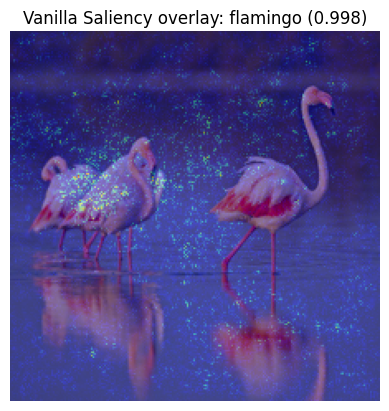

In [7]:
from scripts import explain_vanilla_saliency as evs
sal01 = evs.vanilla_saliency(model,x,pred_idx)

img01 = setup.to_numpy_img01(pil, size=224)
overlay = setup.overlay_heatmap(img01, sal01)

setup.show(overlay, f"Vanilla Saliency overlay: {pred_name} ({pred_prob:.3f})")
plt.imsave("outputs/saliency_overlay.png", overlay)
plt.imsave("outputs/saliency_heatmap.png", sal01, cmap="jet")


## Part C — SmoothGrad (denoise saliency)

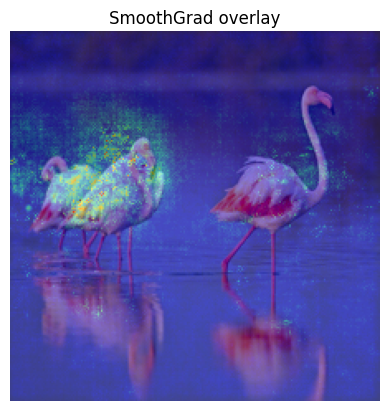

In [8]:
from scripts import xai_methods as xm
from scripts import explain_smooth_grad as xsm

sg = xsm.smoothgrad(model, x.detach(), pred_idx, n_samples=30, noise_sigma=0.12)
overlay_sg = setup.overlay_heatmap(img01, sg)

setup.show(overlay_sg, "SmoothGrad overlay")
plt.imsave("outputs/smoothgrad_overlay.png", overlay_sg)
plt.imsave("outputs/smoothgrad_heatmap.png", sg, cmap="jet")


## Part D — Integrated Gradients

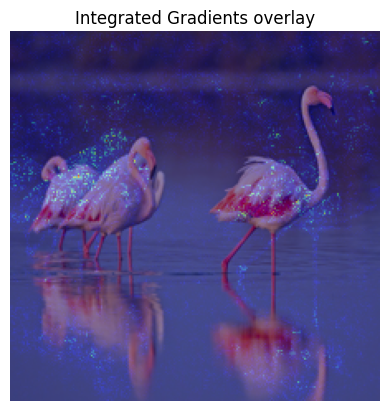

In [9]:
ig = xm.integrated_gradients(model, x.detach(), pred_idx, baseline=torch.zeros_like(x), steps=50)
overlay_ig = setup.overlay_heatmap(img01, ig)

setup.show(overlay_ig, "Integrated Gradients overlay")
plt.imsave("outputs/ig_overlay.png", overlay_ig)
plt.imsave("outputs/ig_heatmap.png", ig, cmap="jet")

## Part E — Compare all gradient methods quickly

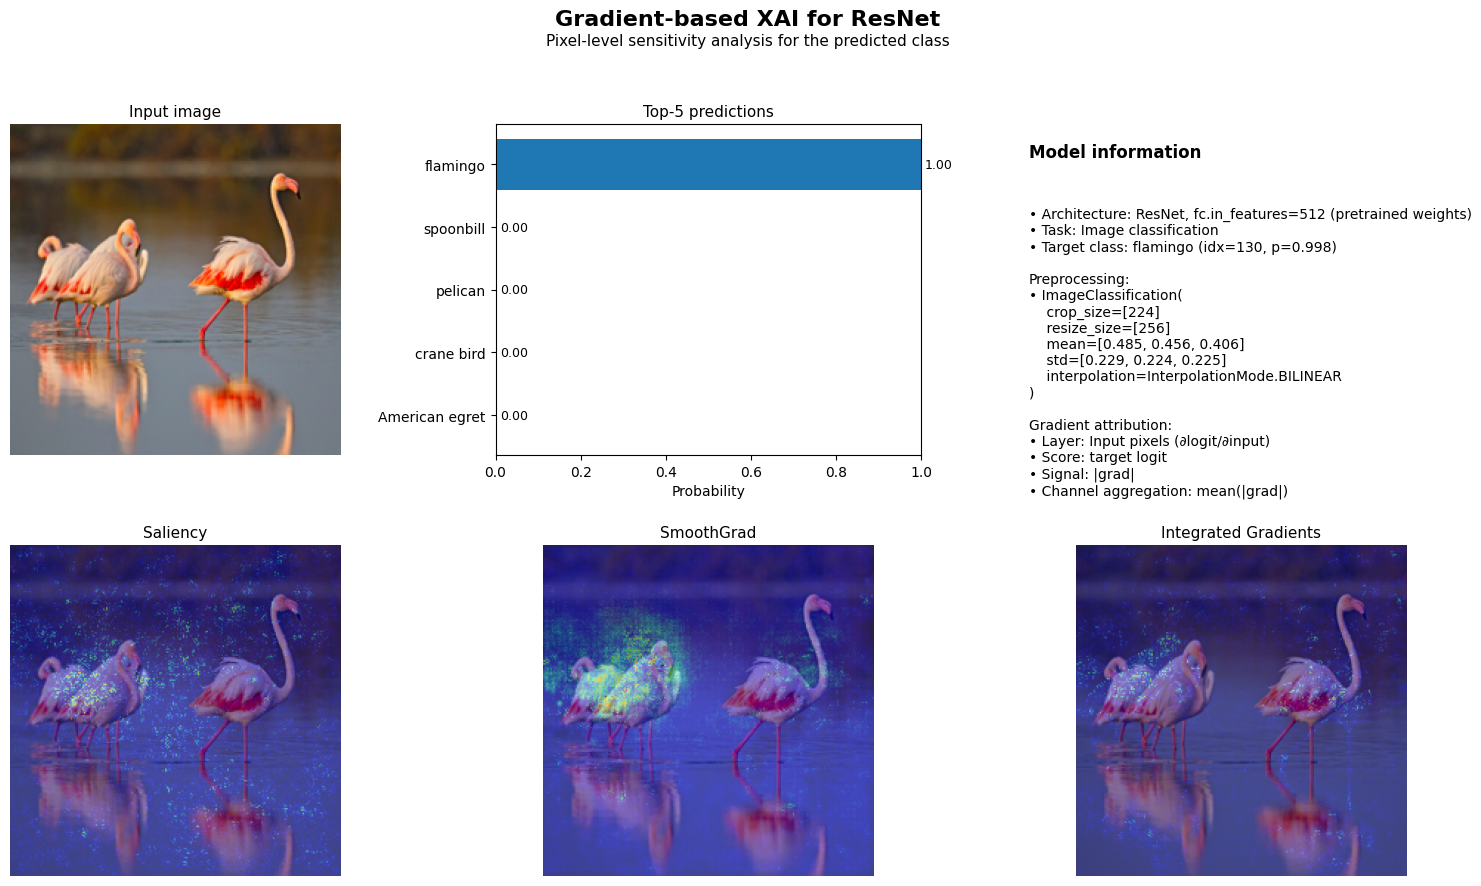

In [10]:
# ---------- Model & explanation metadata (AUTO) ----------
def _describe_model(model):
    cls = model.__class__.__name__
    # try to surface something useful for common torchvision models
    extra = ""
    if hasattr(model, "fc") and hasattr(model.fc, "in_features"):
        extra = f", fc.in_features={model.fc.in_features}"
    elif hasattr(model, "classifier"):
        extra = ", has classifier head"
    return f"{cls}{extra}"

def _describe_preprocess(preprocess):
    # torchvision weights.transforms() returns a Transform pipeline with .transforms list
    try:
        parts = [t.__class__.__name__ for t in preprocess.transforms]
        return " → ".join(parts)
    except Exception:
        return str(preprocess)

architecture = _describe_model(model)
preproc_desc = _describe_preprocess(preprocess)

model_name = f"{architecture} (pretrained weights)"
grad_layer = "Input pixels (∂logit/∂input)"   # true for your saliency/smoothgrad/IG implementation
target_info = f"Target class: {pred_name} (idx={pred_idx}, p={pred_prob:.3f})"


# ---------- Top-5 class probabilities ----------
topk = 5
top_probs, top_idx = probs[0].topk(topk)
top_probs = top_probs.cpu().numpy()
top_idx = top_idx.cpu().numpy()
top_labels = [class_names[i] for i in top_idx]

# ---------- Figure: 2 rows x 3 columns ----------
fig, axes = plt.subplots(2, 3, figsize=(16, 9))

# ===== Row 1 =====

# (1,1) Input image
axes[0, 0].imshow(img01)
axes[0, 0].set_title("Input image", fontsize=11)
axes[0, 0].axis("off")

# (1,2) Top-5 class probabilities
y_pos = np.arange(topk)
axes[0, 1].barh(y_pos, top_probs)
axes[0, 1].set_yticks(y_pos)
axes[0, 1].set_yticklabels(top_labels)
axes[0, 1].invert_yaxis()
axes[0, 1].set_xlim(0, 1.0)
axes[0, 1].set_xlabel("Probability")
axes[0, 1].set_title("Top-5 predictions", fontsize=11)

for i, p in enumerate(top_probs):
    axes[0, 1].text(p + 0.01, i, f"{p:.2f}", va="center", fontsize=9)

# (1,3) Model info panel
axes[0, 2].axis("off")
axes[0, 2].text(
    0.0, 0.9,
    "Model information",
    fontsize=12, fontweight="bold", transform=axes[0, 2].transAxes
)
axes[0, 2].text(
    0.0, 0.75,
    f"• Architecture: {model_name}\n"
    f"• Task: Image classification\n"
    f"• {target_info}\n\n"
    f"Preprocessing:\n"
    f"• {preproc_desc}\n\n"
    f"Gradient attribution:\n"
    f"• Layer: {grad_layer}\n"
    f"• Score: target logit\n"
    f"• Signal: |grad|\n"
    f"• Channel aggregation: mean(|grad|)",
    fontsize=10,
    transform=axes[0, 2].transAxes,
    va="top"
)


# ===== Row 2 =====

# (2,1) Saliency
axes[1, 0].imshow(overlay)
axes[1, 0].set_title("Saliency", fontsize=11)
axes[1, 0].axis("off")

# (2,2) SmoothGrad
axes[1, 1].imshow(overlay_sg)
axes[1, 1].set_title("SmoothGrad", fontsize=11)
axes[1, 1].axis("off")

# (2,3) Integrated Gradients
axes[1, 2].imshow(overlay_ig)
axes[1, 2].set_title("Integrated Gradients", fontsize=11)
axes[1, 2].axis("off")

# ---------- Global title ----------
fig.suptitle(f"Gradient-based XAI for {model.__class__.__name__}",fontsize=16,fontweight="bold",y=0.98)
fig.text(0.5, 0.94,"Pixel-level sensitivity analysis for the predicted class",ha="center",fontsize=11)
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()
fig.savefig("outputs/grad_methods_2x3_with_metadata.png",dpi=200,bbox_inches="tight")